In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### batch generator , start of each video

In [2]:
import cv2
import numpy as np
import random
from os import listdir
from os.path import join

def video_batch_generator(folder_path, sequence_size=28, gen_batch_size=2, image_width=112, image_height=112, frame_step=2):

    video_files = [f for f in sorted(listdir(folder_path)) if f.endswith(('.avi', '.mp4'))]

    while True:
        frames = []
        sequences = []

        random.shuffle(video_files)

        for video_file in video_files:
            video_path = join(folder_path, video_file)
            cap = cv2.VideoCapture(video_path)
            total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))

            # start processing frames from beggenning of video
            max_frames_to_read = sequence_size * frame_step
            frames_read = 0

            while frames_read < max_frames_to_read and len(frames) < sequence_size:
                ret, frame = cap.read()
                if not ret:
                    break

                # Resize and preprocess the frame
                frame = cv2.resize(frame, (image_width, image_height))
                frame = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
                frame = np.expand_dims(frame.astype(np.float32) / 255.0, axis=-1)
                frames.append(frame)
                frames_read += 1

                # Skip frames based on frame_step
                for _ in range(frame_step - 1):
                    if frames_read < max_frames_to_read:
                        cap.read()
                        frames_read += 1

            cap.release()

            # collect frames for one sequence, store it
            if len(frames) == sequence_size:
                sequences.append(np.array(frames))
                frames = []  # reset frames

            # get a batch when enough sequences are collected
            if len(sequences) == gen_batch_size:
                batch_sequences = np.array(sequences)  # Shape: (gen_batch_size, sequence_size, image_height, image_width, 1)
                sequences = []  # Reset sequences for the next batch

                # Yield the batch as input and target (for VAE, input == target)
                yield batch_sequences, batch_sequences

        # If no sequences are collected, reshuffle and retry
        if not sequences:
            random.shuffle(video_files)

        # Yield any remaining sequences as a final smaller batch if there are any
        if sequences:
            batch_sequences = np.array(sequences)
            yield batch_sequences, batch_sequences

### convLSTM VAE , extra LSTM layer

In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Input, Dense, Conv2DTranspose, ConvLSTM2D, Conv2D, TimeDistributed, BatchNormalization, Reshape, Flatten, Lambda, Layer
from tensorflow.keras.layers import Reshape, BatchNormalization, Lambda
from tensorflow.keras.models import Model
from tensorflow.keras import backend as K
from tensorflow.keras.losses import binary_crossentropy
from tensorflow.keras.callbacks import TensorBoard
from tensorflow.keras.saving import register_keras_serializable

@register_keras_serializable()
# Sampling from an isotropic unit Gaussian
def sample_z(args):
    mu, sigma = args
    batch = K.shape(mu)[0]
    dim = K.int_shape(mu)[1]
    eps = K.random_normal(shape=(batch, dim))
    return mu + K.exp(sigma / 2) * eps

@register_keras_serializable()
class Sampling(Layer):
    def call(self, inputs):
        mu, sigma = inputs
        epsilon = K.random_normal(shape=K.shape(mu), mean=0., stddev=1.0)
        return mu + K.exp(0.5 * sigma) * epsilon

def build_encoder(image_width, image_height, latent_dim, sequence_size, num_channels):
    inputs = Input(shape=(sequence_size, image_width, image_height, num_channels), name='encoder_input')

    # Encoder Layers
    x = TimeDistributed(Conv2D(64, (11, 11), strides=2, padding="same"))(inputs)
    x = BatchNormalization()(x)


    # Add the second ConvLSTM2D layer
    x = ConvLSTM2D(32, (5, 5), padding="same", return_sequences=True, activation="relu")(x)
    x = BatchNormalization()(x)

    # Flatten and Latent Space
    conv_shape = K.int_shape(x)  # Save the shape for decoder (if needed)
    x = Flatten()(x)
    x = Dense(latent_dim)(x)
    x = BatchNormalization()(x)
    mu = Dense(latent_dim, name='latent_mu')(x)
    sigma = Dense(latent_dim, name='latent_sigma')(x)

    # Sampling Layer
    z = Sampling(name='z')([mu, sigma])

    # Encoder Model
    encoder = Model(inputs, [mu, sigma, z], name='encoder')

    # Return both the encoder and the conv_shape separately
    return encoder, conv_shape


    # decoder

def build_decoder(latent_dim, conv_shape):
    d_i = Input(shape=(latent_dim,), name='decoder_input')

    # Expand the latent space back into the shape suitable for ConvLSTM2D
    x = Dense(np.prod(conv_shape[1:]), activation='relu')(d_i)
    x = BatchNormalization()(x)
    x = Reshape(conv_shape[1:])(x)

    # Add the first ConvLSTM2D layer
    x = ConvLSTM2D(32, (5, 5), padding="same", return_sequences=True, activation="relu")(x)
    x = BatchNormalization()(x)

    # TimeDistributed Conv2DTranspose to upsample
    x = TimeDistributed(Conv2DTranspose(64, (5, 5), strides=2, padding="same"))(x)
    x = BatchNormalization()(x)

    # Ensure output is still 112x112 by reducing the strides to 1 in the final Conv2DTranspose layer
    o = TimeDistributed(Conv2DTranspose(1, (5, 5), strides=1, activation='sigmoid', padding='same', name='decoder_output'))(x)

    # Instantiate and return the decoder model
    decoder = Model(d_i, o, name='decoder')
    return decoder

### convLSTM vae

In [3]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Input, Dense, Conv2DTranspose, ConvLSTM2D, Conv2D, TimeDistributed, BatchNormalization, Reshape, Flatten, Lambda, Layer
from tensorflow.keras.layers import Reshape, BatchNormalization, Lambda
from tensorflow.keras.models import Model
from tensorflow.keras import backend as K
from tensorflow.keras.losses import binary_crossentropy
from tensorflow.keras.callbacks import TensorBoard
from tensorflow.keras.saving import register_keras_serializable


@register_keras_serializable()
class Sampling(Layer):
    def call(self, inputs):
        mu, sigma = inputs
        epsilon = K.random_normal(shape=K.shape(mu), mean=0., stddev=1.0)
        return mu + K.exp(0.5 * sigma) * epsilon


def build_encoder(image_width, image_height, latent_dim, sequence_size, num_channels):
    inputs = Input(shape=(sequence_size, image_width, image_height, num_channels), name='encoder_input')

    # Encoder Layers
    x = TimeDistributed(Conv2D(128, (11, 11), strides=2, padding="same"))(inputs)
    x = BatchNormalization()(x)
    x = TimeDistributed(Conv2D(64, (5, 5), strides=2, padding="same"))(x)
    x = BatchNormalization()(x)
    x = ConvLSTM2D(16, (3, 3), padding="same", return_sequences=True, activation="relu")(x)                # edited
    x = BatchNormalization()(x)

    # Flatten make Latent Space
    conv_shape = K.int_shape(x)  # shape for decoder
    x = Flatten()(x)
    x = Dense(latent_dim)(x)
    x = BatchNormalization()(x)
    mu = Dense(latent_dim, name='latent_mu')(x)
    sigma = Dense(latent_dim, name='latent_sigma')(x)


    #  sampling layer
    z = Sampling(name='z')([mu, sigma])

    # model the encoder
    encoder = Model(inputs, [mu, sigma, z], name='encoder')

    # Return both the encoder and the conv_shape separately
    return encoder, conv_shape



In [4]:
## working decoder

def build_decoder(latent_dim, conv_shape):
    d_i = Input(shape=(latent_dim,), name='decoder_input')

    # Expand the latent space back into the shape suitable for ConvLSTM2D
    x = Dense(np.prod(conv_shape[1:]), activation='relu')(d_i)
    x = BatchNormalization()(x)
    x = Reshape(conv_shape[1:])(x)

    # ConvLSTM2D layer to process the time-distributed sequence
    x = ConvLSTM2D(16, (3, 3), padding="same", return_sequences=True)(x)                   # edited
    x = BatchNormalization()(x)

    # TimeDistributed Conv2DTranspose to upsample and reconstruct the frames
    x = TimeDistributed(Conv2DTranspose(64, (5, 5), strides=2, padding="same"))(x)
    x = BatchNormalization()(x)

    # Add another Conv2DTranspose layer to further upsample to (112, 112)
    o = TimeDistributed(Conv2DTranspose(1, (5, 5), strides=2, activation='sigmoid', padding='same', name='decoder_output'))(x)

    # Instantiate and return the decoder model
    decoder = Model(d_i, o, name='decoder')
    return decoder

### loss function

In [5]:
# BCE, and entanglement beta

from tensorflow.keras.layers import Layer
from tensorflow.keras.utils import register_keras_serializable
import tensorflow as tf
from tensorflow.keras import backend as K

@register_keras_serializable()
class VAELossLayer(Layer):
    def __init__(self, beta=1.0, **kwargs):
        super(VAELossLayer, self).__init__(**kwargs)
        self.beta = beta

    def call(self, inputs):
        original, reconstructed, mu, sigma = inputs
        # Flatten the input and reconstructed output for BCE calculation
        original = tf.reshape(original, [tf.shape(original)[0], -1])  # Dynamically handle batch size
        reconstructed = tf.reshape(reconstructed, [tf.shape(reconstructed)[0], -1])

        # Reconstruction loss using Binary Cross-Entropy (BCE)
        reconstruction_loss = tf.reduce_mean(
            tf.keras.losses.binary_crossentropy(original, reconstructed)
        )

        # KL divergence loss
        kl_loss = -0.5 * K.sum(1 + sigma - K.square(mu) - K.exp(sigma), axis=-1)

        # Apply beta to the KL loss
        kl_loss = self.beta * kl_loss

        # Calculate the total loss
        total_loss = K.mean(reconstruction_loss + kl_loss)

        # Add the loss to the model
        self.add_loss(total_loss)

        # Return the reconstructed output
        return reconstructed


### set up hyperparameter tuning

In [ ]:
pip install -U keras-tuner

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.1/129.1 kB 8.8 MB/s eta 0:00:00


In [ ]:
import keras_tuner as kt

# Constants for the LSTM
image_width  = 112
image_height = 112
num_channels = 1
sequence_size = 30
model_batch_size = 2
frame_step = 2


# Define hyperparameters
#no_epochs = 20

def vae_hypermodel(hp):
    # Hyperparameters to tune
    latent_dim = hp.Int('latent_dim', min_value=64, max_value=256, step=32)
    learning_rate = hp.Float('learning_rate', min_value=1e-5, max_value=1e-3, sampling='log')
    beta = hp.Float('beta', min_value=1.0, max_value=10.0, step=1.0)
    #model_batch_size = hp.Choice('gen_batch_size', values=[2, 4, 8])

    # clear session
    tf.keras.backend.clear_session()

    # init encoder and decoder with the selected hps
    encoder, conv_shape = build_encoder(image_width, image_height, latent_dim, sequence_size, num_channels)
    decoder = build_decoder(latent_dim, conv_shape)

    # Define the VAE model  and loss func with teh hps
    inputs = encoder.input
    mu, sigma, z = encoder.output
    reconstructed = decoder(z)
    outputs = VAELossLayer(beta=beta)([inputs, reconstructed, mu, sigma])

    vae = Model(inputs, outputs, name='vae')

    # Compile with chosen learning rate
    vae.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate))

    return vae

In [ ]:
# define the datasets from the batch generator

# training and validation splits are in different folder

training_path = '/content/drive/MyDrive/kaggle_data/input/echonet-dynamic/EchoNet-Dynamic/Videos/TRAIN/'
val_path = '/content/drive/MyDrive/kaggle_data/input/echonet-dynamic/EchoNet-Dynamic/Videos/VAL/'



# training dataset
train_gen = video_batch_generator(
    training_path,
    sequence_size=sequence_size,
    gen_batch_size = model_batch_size,
    image_width=image_width,
    image_height=image_height,
    frame_step=frame_step
)

# validation dataset
val_gen = video_batch_generator(
    val_path,
    sequence_size=sequence_size,
    gen_batch_size= model_batch_size,
    image_width=image_width,
    image_height=image_height,
    frame_step=frame_step
)


In [ ]:
#del tuner

tuner = kt.RandomSearch(
    vae_hypermodel,
    objective='val_loss',
    max_trials=5,  # Number of different hyperparameter combinations to try
    directory='vae_tuning',
    project_name='video_vae_tuning'
)

In [ ]:
import os
import math
from tensorflow.keras.callbacks import EarlyStopping

# Define early stopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
# Clear session
tf.keras.backend.clear_session()

# train 300, total frames of dataset 1770636
#total_frames_train = 53119
#total_frames_val = 7083
#val 50, gen_batch_size 2



# Define hyperparameters
no_epochs = 10
 # Use steps_per_epoch based on estimated sample count and tuned batch size
steps_per_epoch_train = 300 // model_batch_size  # Adjust based on your dataset
steps_per_epoch_val = 50 // model_batch_size     # Adjust based on your dataset
#steps_per_epoch_train = math.ceil(total_frames_train / sequence_size)
#steps_per_epoch_val = math.ceil(total_frames_train / sequence_size)

tuner.search(
    train_gen,
    epochs=no_epochs,
    steps_per_epoch=steps_per_epoch_train,
    validation_data= val_gen,  # Optional: Use a validation generator if available
    validation_steps = steps_per_epoch_val,
    callbacks=[early_stopping]
)


Trial 5 Complete [00h 00m 12s]

Best val_loss So Far: 134.326904296875
Total elapsed time: 01h 11m 02s


In [ ]:
# Retrieve the best hyperparameters object
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]

# Access and print each hyperparameter
print("Best Hyperparameters:")
print(f"Latent Dimension: {best_hps.get('latent_dim')}")
print(f"Learning Rate: {best_hps.get('learning_rate')}")
print(f"Beta: {best_hps.get('beta')}")

Best Hyperparameters:
Latent Dimension: 64
Learning Rate: 6.255784808783384e-05
Beta: 1.0


In [ ]:
for batch in train_gen:
    print(batch)
    break

NameError: name 'train_gen' is not defined

### initalise and instantise decoder, encoder , VAE convLSTM ,

In [6]:
# dataset for training

#folder_path = '/content/drive/MyDrive/kaggle_data/input/echonet-dynamic/EchoNet-Dynamic/videos_sample/'
#folder_path = '/content/drive/MyDrive/kaggle_data/input/echonet-dynamic/EchoNet-Dynamic/Videos/TRAIN/'
#val_path =  '/content/drive/MyDrive/kaggle_data/input/echonet-dynamic/EchoNet-Dynamic/Videos/VAL/'

folder_path = '/content/drive/MyDrive/kaggle_data/input/echonet-dynamic/EchoNet-Dynamic/full_data/TRAIN/'
val_path =  '/content/drive/MyDrive/kaggle_data/input/echonet-dynamic/EchoNet-Dynamic/full_data/VAL/'


In [9]:
# Define values for model training

# Constants for the LSTM,
#image_width  = 112
#image_height = 112
#num_channels = 1
#sequence_size = 30
#frame_step = 2
#no_epochs = 5


# Constants for the LSTM,
image_width  = 112
image_height = 112
num_channels = 1
sequence_size = 30
frame_step = 2
no_epochs = 2

# hyperparamters

#Best Hyperparameters from last run:
#Latent Dimension: 224
#Learning Rate: 0.00007332570942268777
#Beta: 7
#Batch Size: 2

best_latent_dim   = 224
best_learning_rate = 0.0007332570942268777
best_beta = 7
gen_batch_size = 2


In [10]:
# Create the training generator
train_gen = video_batch_generator(
    folder_path,
    sequence_size=sequence_size,
    gen_batch_size=gen_batch_size,
    image_width=image_width,
    image_height=image_height,
    frame_step=frame_step
)

# create the validation generator
val_gen = video_batch_generator(
    val_path,
    sequence_size=sequence_size,
    gen_batch_size=gen_batch_size,
    image_width=image_width,
    image_height=image_height,
    frame_step=frame_step
)


### Working model inst and training

In [11]:
import os
import gc

# Calculate steps per epoch for train and validation data
steps_per_epoch = len(os.listdir(folder_path)) // gen_batch_size
validation_steps = len(val_path) // gen_batch_size

tf.keras.backend.clear_session()  # Clear session
gc.collect()

encoder, conv_shape = build_encoder(image_width, image_height, best_latent_dim, sequence_size, num_channels)
decoder = build_decoder(best_latent_dim, conv_shape)

inputs = encoder.input
mu, sigma, z = encoder.output
reconstructed = decoder(z)
outputs = VAELossLayer(beta=best_beta)([inputs, reconstructed, mu, sigma])

vae = Model(inputs, outputs, name='vae')
#vae.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=best_learning_rate),metrics=[temporal_loss])
vae.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=best_learning_rate))


encoder.summary()
decoder.summary()
vae.summary()


Model: "encoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ encoder_input             │ (None, 30, 112, 112,   │              0 │ -                      │
│ (InputLayer)              │ 1)                     │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ time_distributed          │ (None, 30, 56, 56,     │         15,616 │ encoder_input[0][0]    │
│ (TimeDistributed)         │ 128)                   │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization       │ (None, 30, 56, 56,     │            512 │ time_distributed[0][0] │
│ (BatchNormalization)      │ 128)                   │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ time_distributed_1        │ (None, 30, 28, 28, 64) │        204,864 │ batch_normalization[0… │
│ (TimeDistributed)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_1     │ (None, 30, 28, 28, 64) │            256 │ time_distributed_1[0]… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv_lstm2d (ConvLSTM2D)  │ (None, 30, 28, 28, 16) │         46,144 │ batch_normalization_1… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_2     │ (None, 30, 28, 28, 16) │             64 │ conv_lstm2d[0][0]      │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ flatten (Flatten)         │ (None, 376320)         │              0 │ batch_normalization_2… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense (Dense)             │ (None, 224)            │     84,295,904 │ flatten[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_3     │ (None, 224)            │            896 │ dense[0][0]            │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ latent_mu (Dense)         │ (None, 224)            │         50,400 │ batch_normalization_3… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ latent_sigma (Dense)      │ (None, 224)            │         50,400 │ batch_normalization_3… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ z (Sampling)              │ (None, 224)            │              0 │ latent_mu[0][0],       │
│                           │                        │                │ latent_sigma[0][0]     │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 84,665,056 (322.97 MB)

 Trainable params: 84,664,192 (322.97 MB)

 Non-trainable params: 864 (3.38 KB)

Model: "decoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ decoder_input (InputLayer)           │ (None, 224)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 376320)              │      84,672,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_4                │ (None, 376320)              │       1,505,280 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ reshape (Reshape)                    │ (None, 30, 28, 28, 16)      │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_lstm2d_1 (ConvLSTM2D)           │ (None, 30, 28, 28, 16)      │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_5                │ (None, 30, 28, 28, 16)      │              64 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed_2 (TimeDistributed) │ (None, 30, 56, 56, 64)      │          25,664 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_6                │ (None, 30, 56, 56, 64)      │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed_3 (TimeDistributed) │ (None, 30, 112, 112, 1)     │           1,601 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 86,223,361 (328.92 MB)

 Trainable params: 85,470,561 (326.04 MB)

 Non-trainable params: 752,800 (2.87 MB)

Model: "vae"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ encoder_input             │ (None, 30, 112, 112,   │              0 │ -                      │
│ (InputLayer)              │ 1)                     │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ time_distributed          │ (None, 30, 56, 56,     │         15,616 │ encoder_input[0][0]    │
│ (TimeDistributed)         │ 128)                   │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization       │ (None, 30, 56, 56,     │            512 │ time_distributed[0][0] │
│ (BatchNormalization)      │ 128)                   │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ time_distributed_1        │ (None, 30, 28, 28, 64) │        204,864 │ batch_normalization[0… │
│ (TimeDistributed)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_1     │ (None, 30, 28, 28, 64) │            256 │ time_distributed_1[0]… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv_lstm2d (ConvLSTM2D)  │ (None, 30, 28, 28, 16) │         46,144 │ batch_normalization_1… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_2     │ (None, 30, 28, 28, 16) │             64 │ conv_lstm2d[0][0]      │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ flatten (Flatten)         │ (None, 376320)         │              0 │ batch_normalization_2… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense (Dense)             │ (None, 224)            │     84,295,904 │ flatten[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_3     │ (None, 224)            │            896 │ dense[0][0]            │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ latent_mu (Dense)         │ (None, 224)            │         50,400 │ batch_normalization_3… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ latent_sigma (Dense)      │ (None, 224)            │         50,400 │ batch_normalization_3… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ z (Sampling)              │ (None, 224)            │              0 │ latent_mu[0][0],       │
│                           │                        │                │ latent_sigma[0][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ decoder (Functional)      │ (None, 30, 112, 112,   │     86,223,361 │ z[0][0]                │
│                           │ 1)                     │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ vae_loss_layer            │ (None, None)           │              0 │ encoder_input[0][0],   │
│ (VAELossLayer)       

 Total params: 170,888,417 (651.89 MB)

 Trainable params: 170,134,753 (649.01 MB)

 Non-trainable params: 753,664 (2.88 MB)

### Train the model

In [ ]:
# Train the model with validation data
history = vae.fit(
    train_gen,
    steps_per_epoch=steps_per_epoch,   # Number of batches in the training generator
    epochs=no_epochs,                  # Total number of epochs
    validation_data=val_gen,           # Validation generator
    validation_steps=validation_steps  # Number of validation batches to run per epoch
)

Epoch 1/2
 458/3160 ━━━━━━━━━━━━━━━━━━━━ 29:49 662ms/step - loss: 706.4770

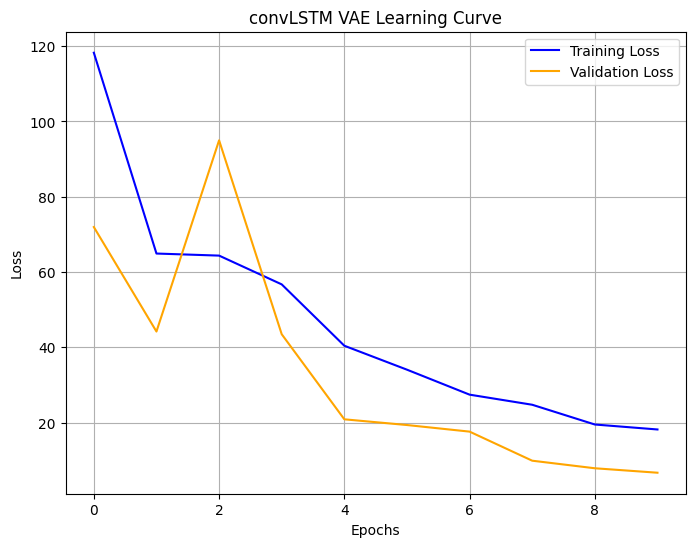

In [ ]:
import matplotlib.pyplot as plt

# Extract the loss values from the history
loss = history.history['loss']
val_loss = history.history['val_loss']  # Validation loss

# Plot the learning curve
plt.figure(figsize=(8, 6))
plt.plot(loss, label='Training Loss', color ='blue')
plt.plot(val_loss, label='Validation Loss', color='orange')


plt.title('convLSTM VAE Learning Curve')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.grid(True)
plt.legend()
plt.show()

### Generate a new clip from the decoder to see the efficecy of the model.

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

def generate_and_visualize_clip(decoder, latent_dim, sequence_size=28):

    # Sample a latent vector from a standard Gaussian distribution
    sampled_z = np.random.normal(size=(1, latent_dim))  # Shape (1, latent_dim) for a single sample

    # Use the decoder to generate a sequence of frames
    generated_clip = decoder.predict(sampled_z)  # Shape: (1, sequence_size, 112, 112, 1)
    generated_clip = generated_clip[0]  # Remove the batch dimension for visualization

    # Visualize the generated sequence frame by frame
    print(f"Visualizing a generated sequence of shape {generated_clip.shape}")
    for i in range(sequence_size):
        frame = generated_clip[i].squeeze()  # Remove channel dimension for display if it's (112, 112, 1)

        plt.figure(figsize=(2, 2))
        plt.imshow(frame, cmap='gray')
        plt.title(f"Frame {i + 1}")
        plt.axis('off')
        plt.show()

In [ ]:
import numpy as np
import cv2
from IPython.display import Video, display

def generate_and_save_clip_with_cv2(decoder, latent_dim, sequence_size=28, output_path='generated_clip.mp4', fps=10, upscale_shape=(224, 224)):

    #  Sample a latent vector from a standard Gaussian distribution
    sampled_z = np.random.normal(size=(1, latent_dim))  # Shape (1, latent_dim) for a single sample

    # Use the decoder to generate a sequence of frames
    generated_clip = decoder.predict(sampled_z)  # Shape: (1, sequence_size, 112, 112, 1)
    generated_clip = generated_clip[0]  # Remove the batch dimension for saving

    #  Prepare frames for saving to video
    up_height, up_width = upscale_shape
    video_writer = cv2.VideoWriter(output_path, cv2.VideoWriter_fourcc(*'mp4v'), fps, (up_width, up_height))

    for i in range(sequence_size):
        frame = generated_clip[i].squeeze()  # Shape: (112, 112)

        # Normalize frame values to the full range [0, 255]
        frame = (frame - frame.min()) / (frame.max() - frame.min() + 1e-8)  # Normalize between 0 and 1
        frame = (frame * 255).astype(np.uint8)  # Convert to 8-bit grayscale image (0-255)

        # Resize the frame to the upscale dimensions (224, 224)
        frame = cv2.resize(frame, (up_width, up_height), interpolation=cv2.INTER_LINEAR)

        # Ensure frame shape is correct for video writing (H, W, 3)
        if len(frame.shape) == 2:
            frame = cv2.cvtColor(frame, cv2.COLOR_GRAY2BGR)  # Convert to RGB format

        # Write the frame to the video file
        video_writer.write(frame)

    #  Release the video writer
    video_writer.release()
    print(f"Generated video saved to {output_path}")


In [ ]:
# generate video:
latent_dim = 224
base = '/content/drive/MyDrive/kaggle_data/input/echonet-dynamic/EchoNet-Dynamic/'
generate_and_save_clip_with_cv2(decoder, latent_dim=latent_dim, sequence_size=sequence_size, upscale_shape=(224,224),output_path= base +'generated_clip.mp4', fps=10)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Generated video saved to /content/drive/MyDrive/kaggle_data/input/echonet-dynamic/EchoNet-Dynamic/generated_clip.mp4


1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Visualizing a generated sequence of shape (30, 112, 112, 1)


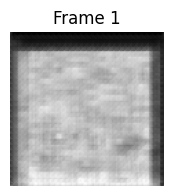

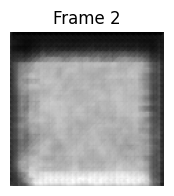

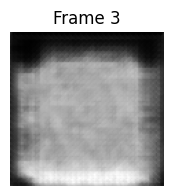

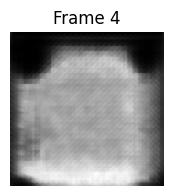

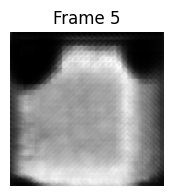

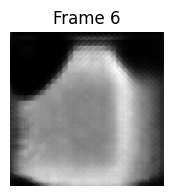

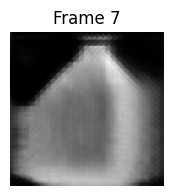

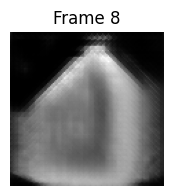

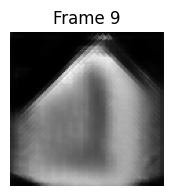

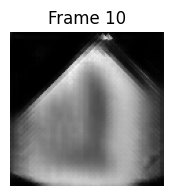

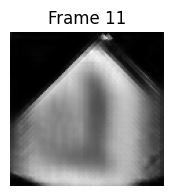

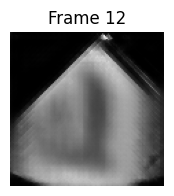

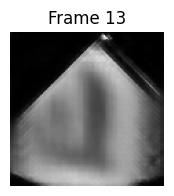

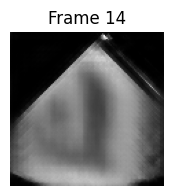

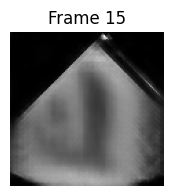

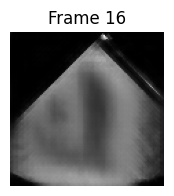

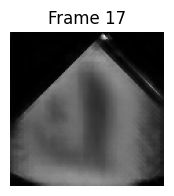

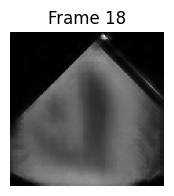

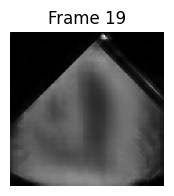

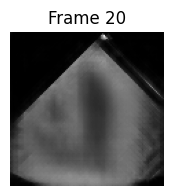

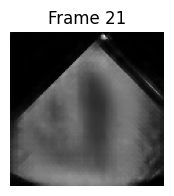

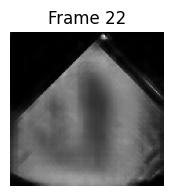

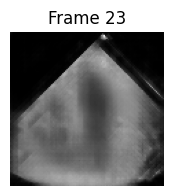

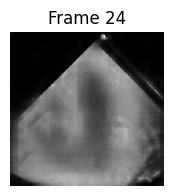

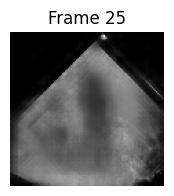

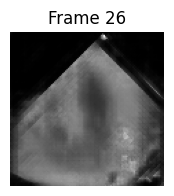

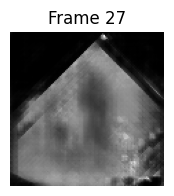

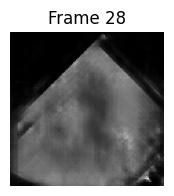

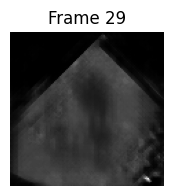

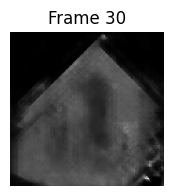

In [ ]:
generate_and_visualize_clip(decoder, latent_dim= 224, sequence_size=sequence_size)

In [ ]:


# Save the entire model after training
model_save_path = "/content/drive/MyDrive/kaggle_data/input/echonet-dynamic/EchoNet-Dynamic/vae_model_10_epochs_more_layers_beta_1.h5"
vae.save(model_save_path)
print(f"Model saved to {model_save_path}")

vae.save('/content/drive/MyDrive/kaggle_data/input/echonet-dynamic/EchoNet-Dynamic/vae_model_10_epochs_more_layers_beta_1.keras')

Model saved to /content/drive/MyDrive/kaggle_data/input/echonet-dynamic/EchoNet-Dynamic/vae_model_10_epochs_more_layers_beta_1.h5
